### Dataset Generation

In [6]:
import pandas as pd
import numpy as np

def generate_turbine_data(n_turbines=10, max_hours=2000):
    all_data = []
    
    for turbine_id in range(n_turbines):
        # Initial healthy states
        current_temp = 150.0  # Celsius
        current_vib = 1.5     # mm/s (Velocity)
        load_rpm = 3000       # Standard RPM
        
        # Degradation starts at a random hour
        failure_point = np.random.randint(max_hours // 2, max_hours)
        
        for hour in range(failure_point + 1):
            # 1. Base levels with small random noise
            noise_temp = np.random.normal(0, 0.5)
            noise_vib = np.random.normal(0, 0.05)
            
            # 2. Add degradation effect as we get closer to failure
            degradation = (hour / failure_point) ** 4  # Exponential wear
            
            temp = current_temp + (25 * degradation) + noise_temp
            vib = current_vib + (4.0 * degradation) + noise_vib
            
            # 3. Calculate Targets
            rul = failure_point - hour
            failure_risk = 1 / (1 + np.exp(-10 * (degradation - 0.8))) # Sigmoid risk
            
            all_data.append({
                'Turbine_ID': f'T{turbine_id:03}',
                'Usage_Hours': hour,
                'Temperature': round(temp, 2),
                'Vibration': round(vib, 2),
                'Load_RPM': load_rpm,
                'RUL': rul,
                'Failure_Risk': round(failure_risk, 4)
            })
            
    return pd.DataFrame(all_data)

# Generate and Save
df = generate_turbine_data(n_turbines=5)
print(df.tail(10)) # Show data leading up to a failure

     Turbine_ID  Usage_Hours  Temperature  Vibration  Load_RPM  RUL  \
7387       T004         1986       174.37       5.44      3000    9   
7388       T004         1987       174.94       5.44      3000    8   
7389       T004         1988       173.84       5.37      3000    7   
7390       T004         1989       174.30       5.42      3000    6   
7391       T004         1990       174.25       5.45      3000    5   
7392       T004         1991       175.27       5.55      3000    4   
7393       T004         1992       174.90       5.49      3000    3   
7394       T004         1993       176.04       5.46      3000    2   
7395       T004         1994       175.39       5.55      3000    1   
7396       T004         1995       174.35       5.58      3000    0   

      Failure_Risk  
7387        0.8607  
7388        0.8630  
7389        0.8653  
7390        0.8676  
7391        0.8699  
7392        0.8721  
7393        0.8744  
7394        0.8765  
7395        0.8787  
7396    

### Data Analysis and Correlation Heatmap

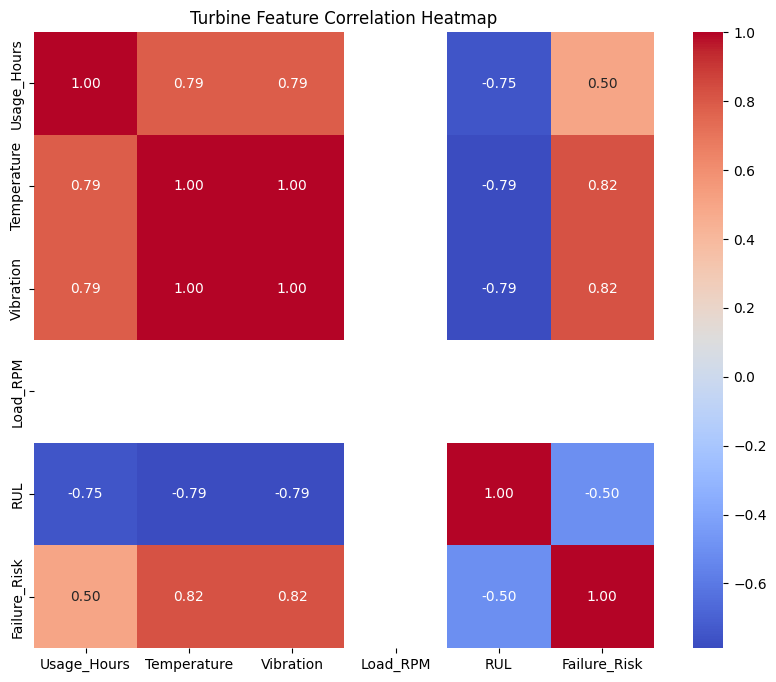

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor

# Assuming 'df' is the dataframe generated in the previous step
# 1. Visualization: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.drop(columns=['Turbine_ID']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Turbine Feature Correlation Heatmap")
plt.show()

### Data Splitting and Scaling

In [13]:
# Define Features and Targets
X = df[['Usage_Hours', 'Temperature', 'Vibration', 'Load_RPM']]
y = df[['Failure_Risk', 'RUL']]

# Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fitting the Multi-Output Model

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

# We use MultiOutputRegressor to predict Failure_Risk and RUL simultaneously
model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))

# Fit the model
model.fit(X_train_scaled, y_train)

# Make Predictions
predictions = model.predict(X_test_scaled)
pred_df = pd.DataFrame(predictions, columns=['Pred_Failure_Risk', 'Pred_RUL'])

print("Model Training Complete.")
print(pred_df.head())

Model Training Complete.
   Pred_Failure_Risk     Pred_RUL
0           0.014811   391.593614
1           0.042952   293.847644
2           0.001819   693.054266
3           0.000435  1330.240660
4           0.000470  1083.766491


### Evaluation Logic

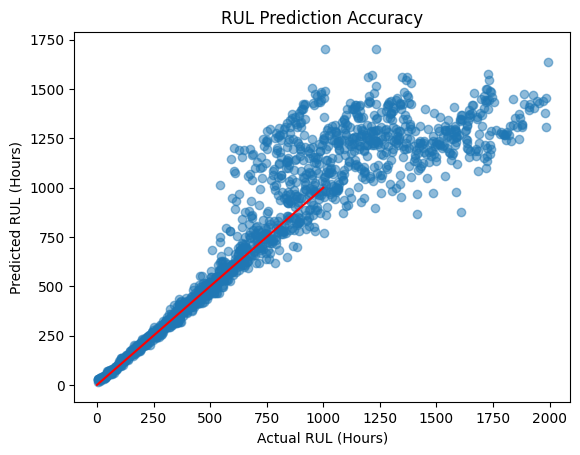

In [15]:
plt.scatter(y_test['RUL'], pred_df['Pred_RUL'], alpha=0.5)
plt.xlabel("Actual RUL (Hours)")
plt.ylabel("Predicted RUL (Hours)")
plt.title("RUL Prediction Accuracy")
plt.plot([0, 1000], [0, 1000], color='red') # Diagonal reference line
plt.show()

In [16]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Initialize the Multi-Output Model
# We use XGBoost because it's excellent for these non-linear relationships
base_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)
multi_model = MultiOutputRegressor(base_model)

# 2. Fit the model using your scaled training data
multi_model.fit(X_train_scaled, y_train)

# 3. Make predictions on the test set
y_pred = multi_model.predict(X_test_scaled)

# 4. View a sample comparison
comparison_df = pd.DataFrame({
    'Actual_Risk': y_test['Failure_Risk'].values,
    'Pred_Risk': y_pred[:, 0],
    'Actual_RUL': y_test['RUL'].values,
    'Pred_RUL': y_pred[:, 1]
})

print("Sample Predictions:")
print(comparison_df.head(10))

# 5. Check Accuracy
print(f"\nRUL Accuracy (R2): {r2_score(y_test['RUL'], y_pred[:, 1]):.2f}")

Sample Predictions:
   Actual_Risk  Pred_Risk  Actual_RUL     Pred_RUL
0       0.0133   0.016025         387   381.117737
1       0.0366   0.041756         300   290.119385
2       0.0018   0.002080         713   711.156006
3       0.0003   0.000708         896  1331.510376
4       0.0004   0.000751         902  1113.618774
5       0.0005   0.000808         542   695.032043
6       0.0005   0.000764         568   697.197632
7       0.0003   0.000708         912  1408.411987
8       0.0003   0.000708        1689  1208.063354
9       0.2245   0.255487         186   178.055573

RUL Accuracy (R2): 0.83


In [18]:
import joblib

# Save the multi-output model
joblib.dump(multi_model, 'turbine_model.pkl')

# Save the scaler (essential for processing new inputs correctly)
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!


In [19]:
pip install streamlit

  Using cached streamlit-1.54.0-py3-none-any.whl.metadata (9.8 kB)
  Using cached altair-6.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-6.2.6-py3-none-any.whl.metadata (5.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached gitpython-3.1.46-py3-none-any.whl.metadata (13 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached protobuf-6.33.5-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-23.0.0-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tenacity-9.1.3-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2

  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
